In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
insp = inspect(engine)
print(insp.get_table_names())

['measurement', 'station']


In [9]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
#base.prepare(engine, reflect=True)
base.prepare(autoload_with=engine)
base.classes.keys()

['measurement', 'station']

In [7]:
# View all of the classes that automap found
insp = inspect(engine)
print(insp.get_table_names())

['measurement', 'station']


In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
query = text("SELECT * FROM measurement")
conn = engine.connect()

data = conn.execute(query)

for record in data:''
print(record)

(19550, 'USC00516128', '2017-08-23', 0.45, 76.0)


In [11]:
data = pd.read_sql("SELECT * FROM measurement", engine)
data.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [12]:
data2 = pd.read_sql("SELECT * FROM station", engine)
data2.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date
print("The most recent date in the dataset is:",most_recent_date)

The most recent date in the dataset is: 2017-08-23


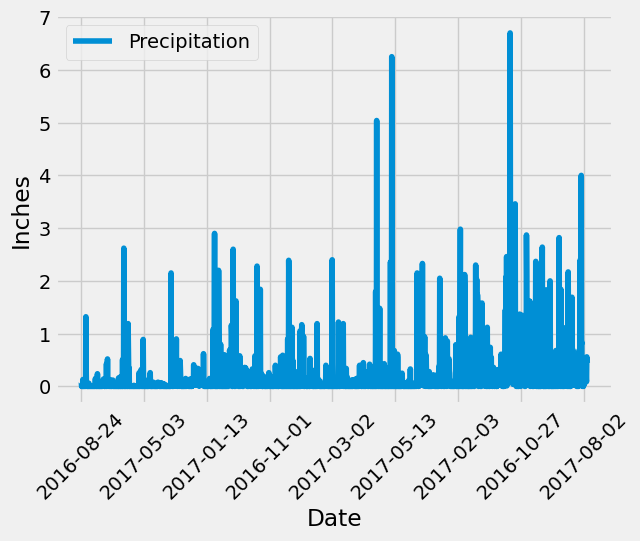

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date>=one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(results, columns=['Date','Precipitation'])

# Sort the dataframe by date

df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data

df = pd.DataFrame(results, columns=['Date','Precipitation']).set_index('Date').dropna()

df.plot(rot=45)
plt.ylabel('Inches')
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset

stdata = pd.read_sql("SELECT * FROM station", engine)
station_count = stdata['station'].count()
print(f"The total number of stations in the data set is {station_count}.")

The total number of stations in the data set is 9.


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_results = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
station_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the 
#lowest, highest, and average temperature.

session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

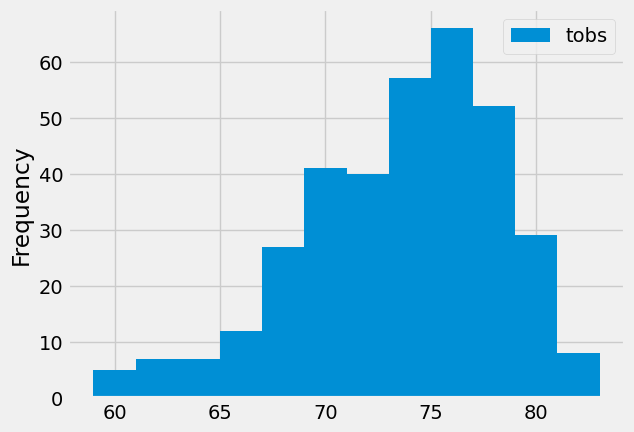

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_2 = session.query(measurement.tobs).filter(measurement.date>=one_year_ago).\
filter(measurement.station == "USC00519281").all()

df_2 = pd.DataFrame(results_2,columns=["tobs"])

df_2.plot.hist(y='tobs', bins = 12)

plt.ylabel('Frequency')
plt.show()

# Close Session

In [20]:
# Close Session
session.close()